<a href="https://colab.research.google.com/github/qcuongning/collab/blob/main/ISIC2017_new_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Với các hàm cần sử dụng backend Keras mà bị lỗi K not contribute cần đổi về keras==2.2.4


The codebase is heavily inspired by the [respotory](https://github.com/qubvel/efficientnet)



# Get Data

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
import json
import cv2
import csv
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications as app
seed = 1234
np.random.seed(seed)

In [ ]:
from zipfile import ZipFile
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
file_id = '1bbKAqUuk7Y1q3xsDSwP07oOXN_GL3SQM'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('COVID-SemiSeg')
with ZipFile('COVID-SemiSeg', 'r') as tt:
  tt.extractall("")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#su dung khi dataset o trong drive neu khong bo qua
%cp drive/My\ Drive/COVID-SemiSeg.zip /content/
with ZipFile('COVID-SemiSeg.zip', 'r') as tt:
  tt.extractall("")

In [ ]:
file_name = 'weights_save'
if not os.path.exists(file_name):
  os.mkdir(file_name)

# Initial Data

lấy các cặp ảnh và mask

ảnh resize về 192x288

mask là binary
đầu ra imgs , masks

In [ ]:
def GetFiles(path):
    file_list, dir_list = [], []
    for dir, subdirs, files in os.walk(path):
        file_list.extend([FJoin(dir, f) for f in files])
        dir_list.extend([FJoin(dir, d) for d in subdirs])
    return file_list, dir_list

def get_mask(image_name,mask_folder):
    mask_path=os.path.join(mask_folder, image_name.replace(".jpg",".png"))
    #print(mask_path)
    img_mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    _,img_mask = cv2.threshold(img_mask,127,255,cv2.THRESH_BINARY)
    #img_mask = img_mask/255
    #plt.imshow(img_mask,cmap='gray')
    img_mask[img_mask<0.5] = 0
    img_mask[img_mask>=0.5] = 1
    return img_mask


def build_data(path,mask_folder,csv_path,img_shapes):
  w,h = img_shapes
  imgs=[]
  masks=[]
  img_name=[]
  if csv_path == None:
    img_name = os.listdir(path)
  else:
    with open(csv_path, 'r') as csvFile:
      reader = csv.reader(csvFile)
      for row in reader:
          img_name.append(row[0])
  n = len(img_name)//20
  for count,file in enumerate(img_name[:]):
        if file.find("super")>0:
          continue
        fullpath= os.path.join(path,file)
        #print(fullpath)
        msk=get_mask(file,mask_folder)
        msk=cv2.resize(msk,(w,h))
        masks.append(msk)
        image=cv2.imread(fullpath)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        #image=image/127.5-1
        image=cv2.resize(image,(w,h))
        imgs.append(image)
        if count%n == 0:
          plt.figure(count//n)
          plt.subplot(1,2,1).imshow(image,cmap='gray')
          #plt.contour(msk,colors='r')
          #plt.draw()
          plt.subplot(1,2,2).imshow(msk, cmap = 'gray')
          plt.show()  
  imgs=np.asarray(imgs,dtype=np.float)
  masks=np.asarray(masks,dtype=np.float).reshape(-1,h,w,1)
  print("shape imgs: ",imgs.shape)
  print("shape masks: ",masks.shape)
  return imgs,masks

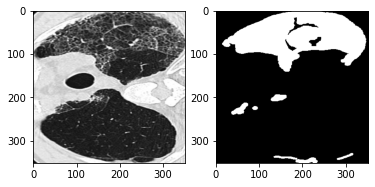

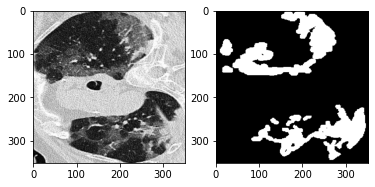

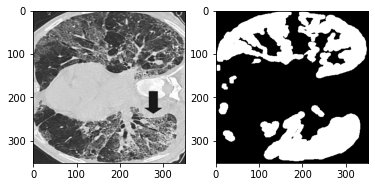

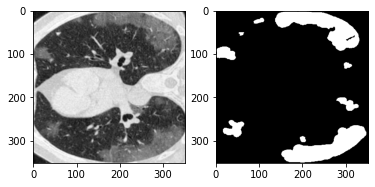

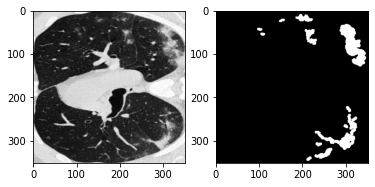

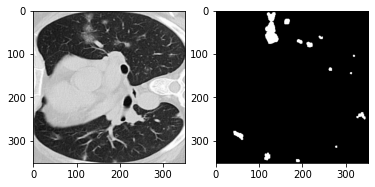

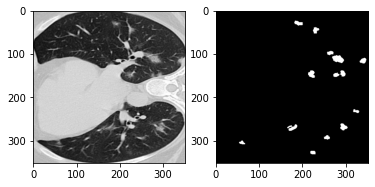

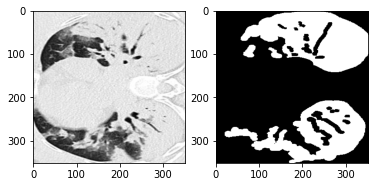

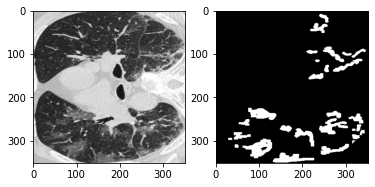

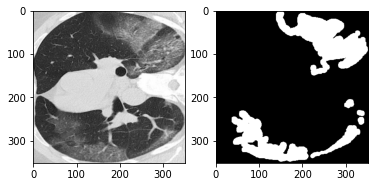

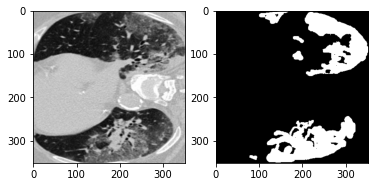

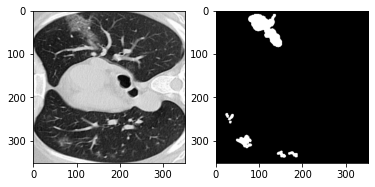

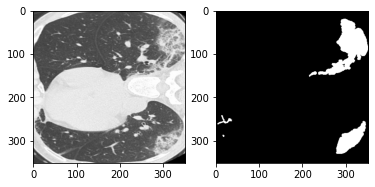

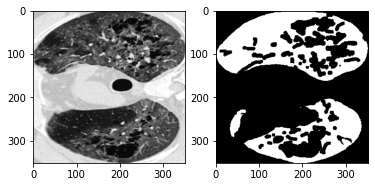

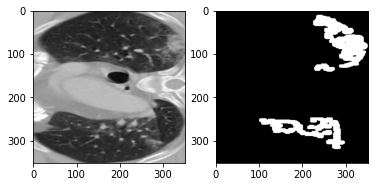

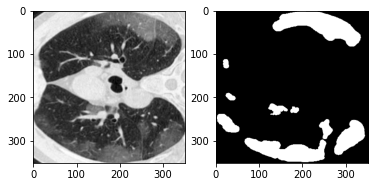

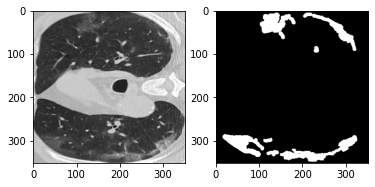

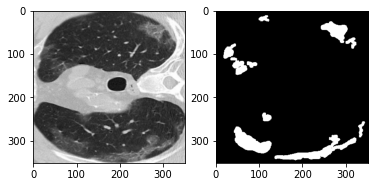

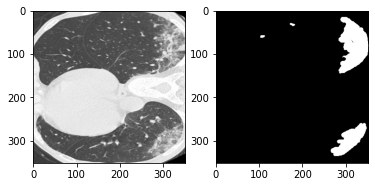

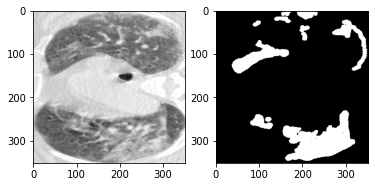

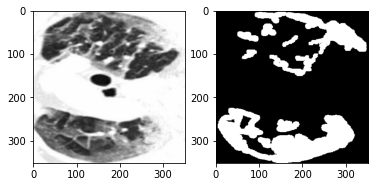

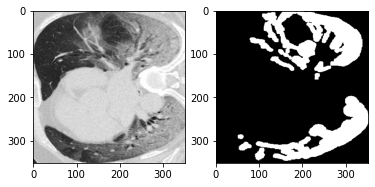

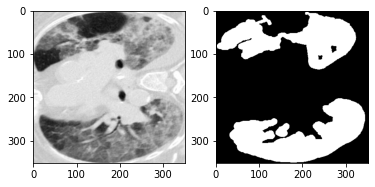

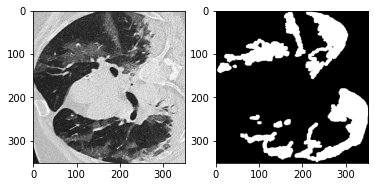

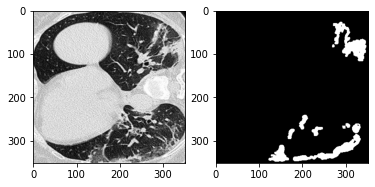

shape imgs:  (50, 352, 352, 3)
shape masks:  (50, 352, 352, 1)
---------------------------------------------------------


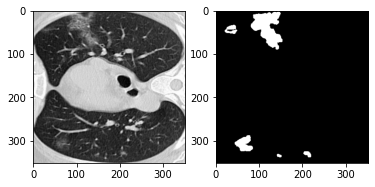

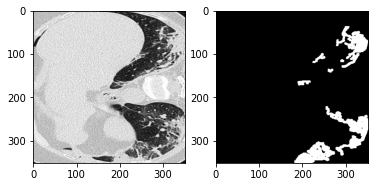

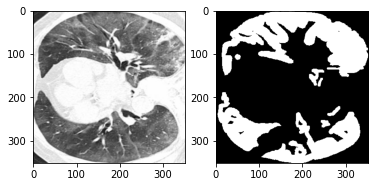

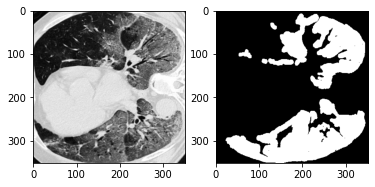

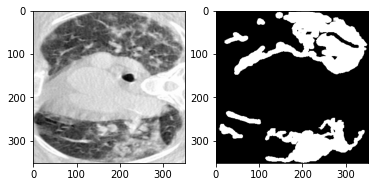

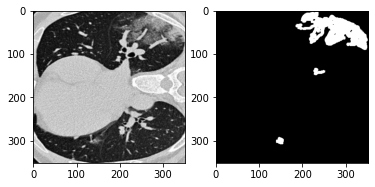

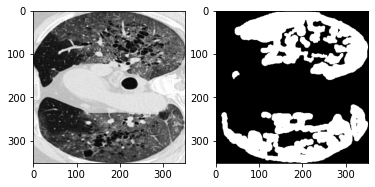

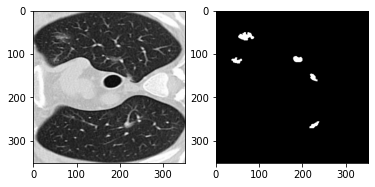

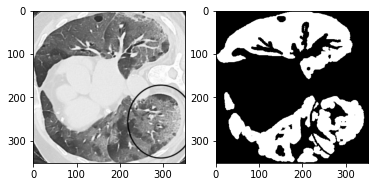

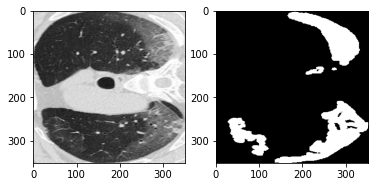

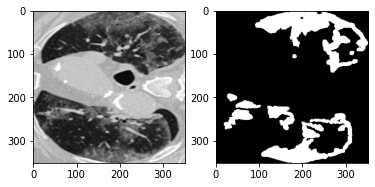

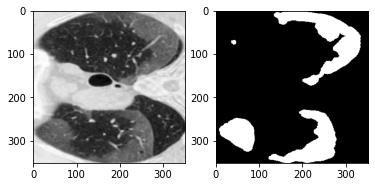

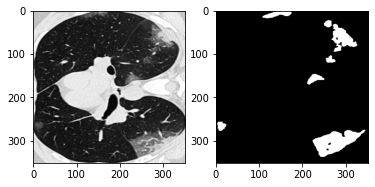

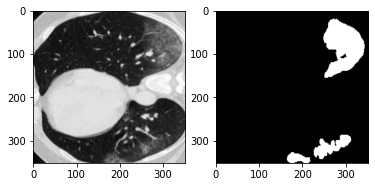

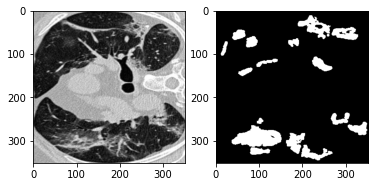

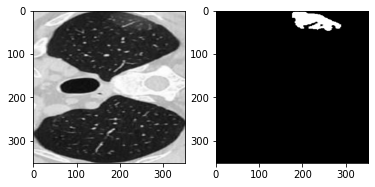

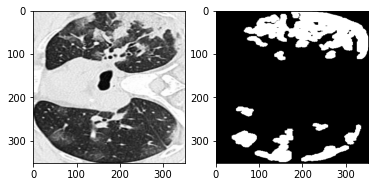

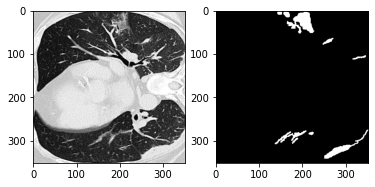

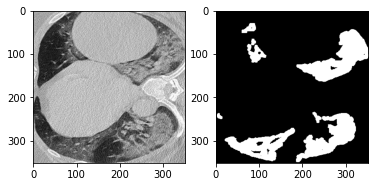

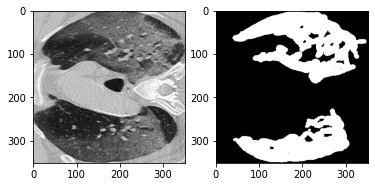

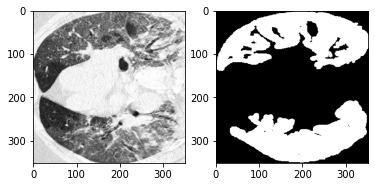

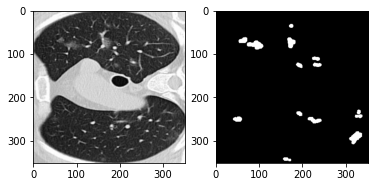

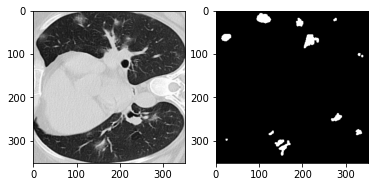

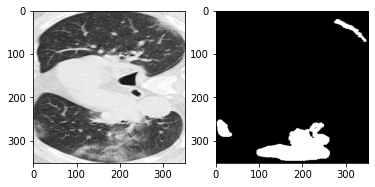

shape imgs:  (48, 352, 352, 3)
shape masks:  (48, 352, 352, 1)


In [ ]:
w = 352
h = 352
folder_train = "/content/COVID-SemiSeg/Dataset/TrainingSet/LungInfection-Train/Doctor-label/Imgs"
mask_train_folder = "/content/COVID-SemiSeg/Dataset/TrainingSet/LungInfection-Train/Doctor-label/GT"
folder_test = "/content/COVID-SemiSeg/Dataset/TestingSet/LungInfection-Test/Imgs"
mask_test_folder = "/content/COVID-SemiSeg/Dataset/TestingSet/LungInfection-Test/GT"
imgs,masks = build_data(folder_train,mask_train_folder, None, (w,h))
print("---------------------------------------------------------")
img_dev,mask_dev = build_data(folder_test,mask_test_folder, None, (w,h))



#loss

In [ ]:
def mvn(tensor):
    '''Performs per-channel spatial mean-variance normalization.'''
    epsilon = 1e-6
    mean = K.mean(tensor, axis=(1,2), keepdims=True)
    std = K.std(tensor, axis=(1,2), keepdims=True)
    mvn = (tensor - mean) / (std + epsilon)
    
    return mvn
def dice_coef(y_true, y_pred, smooth=1.0):
    '''Average dice coefficient per batch.'''
    y_pred = heviside(y_pred,epsilon = 0.01)
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes) #AhopM
    summation = K.sum(y_true + y_pred, axis=axes)
    
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, smooth=1.0)
def gradientLoss2d(input):
    dH = K.abs(input[:, 1:, :, :] - input[:, :-1, :, :])
    dW = K.abs(input[:, :, 1:, :] - input[:, :, :-1, :])
    dH = dH * dH
    dW = dW * dW
    loss = K.sum(dH) + K.sum(dW)
    return loss
def levelsetLoss(y_true, y_pred, ratio = 0.001):
    #print("go")
    outshape = y_pred.shape
    tarshape = y_true.shape
    multi = y_true*y_pred
    c_numerator = K.sum(multi, [1,2])
    c_denominator = K.sum(y_pred, [1,2])
    #print("outshape,tarshape,multi.shape,c_numerator.shape, c_denominator.shape")
    #print(outshape,tarshape,multi.shape,c_numerator.shape, c_denominator.shape)
    c = c_numerator/c_denominator
    #print("s",c.shape)
    c = K.reshape(c, (-1, 1, 1,outshape[3])) 
    #print("c.shape: ", c.shape)
    plevel = y_true - c
    #print("plevel: ", plevel)
    pLoss = plevel * plevel * y_pred
    lossL = K.mean(pLoss)
    #print("lossL: ", lossL)
    lossA = gradientLoss2d(y_pred) * ratio

    return lossL  + dice_coef_loss(y_true, y_pred)


def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)
    return loss
def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall
def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 
def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 
def tversky(y_true, y_pred):
    smooth=0.0
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    y_pred = y_pred[0]
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)
def heviside(x,epsilon=0.1):
    return 1/2*(1+2/3.14159*tf.math.atan(x/epsilon))
def Active_Contour_Loss(y_true, y_pred): 
    epison = 0.1
    Drc = (epison / 3.14159) / (epison * epison + y_pred[:,:,:,0] * y_pred[:,:,:,0])
    Hea = 1/2*(1+2/3.14159*tf.math.atan(y_pred[:,:,:,0]/0.1))

    mean_in = np.ones((h, w))
    mean_out = np.zeros((h, w))

    region_in = K.abs(K.mean( Hea * ((y_true[:,:,:,0] - mean_in)**2) ) ) 
    region_out = K.abs(K.mean( (1-Hea) * ((y_true[:,:,:,0] - mean_out)**2) )) 
    
    return region_in + 2*region_out

# Data Augument

In [ ]:
#from itertools import izip
generator_x = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    #shear_range = 0.1,
    zoom_range = 0.1,
    rotation_range = 180,
    #fill_mode = 'reflect',
    #brightness_range = (0.9,1.1),
)
generator_y = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    #shear_range = 0.1,
    zoom_range = 0.1,
    #brightness_range = (1.0,1.0),
    rotation_range = 180,
    #fill_mode = 'reflect'
)
seed = 1234
batch = 4

x_gen = generator_x.flow(imgs, batch_size = batch, shuffle = False, seed = seed)
y_gen = generator_y.flow(masks, batch_size = batch, shuffle = False, seed = seed)
train_generator = zip(x_gen, y_gen)

#attention gate

In [ ]:
def attention_up_and_concate(down_layer, layer, data_format='channels_last'):
    data_format='channels_last'

    in_channel = down_layer.get_shape().as_list()[3]

    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    layer = attention_block_2d(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))

    concate = my_concat([up, layer])
    return concate
def attention_block_2d(x, g, inter_channel, data_format='channels_last'):
    data_format='channels_last'

    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)

    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)


    f = Activation('relu')(add([theta_x, phi_g]))


    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)

    att_x = multiply([x, rate])

    return att_x

#callback

In [ ]:
class lr_scheduler(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if epoch == 59 or epoch == 79:
      current_lr = K.eval(self.model.optimizer.lr)
      current_lr = current_lr / 10
      K.set_value(self.model.optimizer.lr, current_lr)
      print(K.eval(self.model.optimizer.lr))


class visualize(tf.keras.callbacks.Callback):


    def __init__(self,img,mask):
        super(visualize, self).__init__()
        self.img = img
    def on_epoch_end(self, epoch, logs=None):
       feature_maps = self.model.predict(img)
       fm = feature_maps[0]
       fm = heviside(fm)
       #print(fm.shape)
       square = 2
       print("------------------------")
       #print(feature_maps[-1][0,:3,:3,0])
       print("-------------------------")
       #print(feature_maps[0][0,:3,:3,0])
       plt.subplot(121),plt.imshow(fm[:,:,0],cmap = 'gray')
       plt.subplot(122),plt.imshow(mask[0,:,:,0],cmap = 'gray')
       plt.show()
      #  for fmap in feature_maps[1:]:
      #       ix = 1
      #       for _ in range(square):
      #           for _ in range(square):
      #               # specify subplot and turn of axis
      #               ax = plt.subplot(square, square, ix)
      #               ax.set_xticks([])
      #               ax.set_yticks([])
      #               # plot filter channel in grayscale
      #               if ix > fmap.shape[-1]:
      #                   continue
      #               plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
      #               ix += 1
      #       plt.show()




In [ ]:
def unet(input_size = (192,288,3),classnum=2,pretrained_weights = None):
    data = Input(shape=input_size, dtype='float', name='data')
    mvn0 = Lambda(mvn)(data)
    conv1 = Conv2D(64, 3, padding = 'same')(mvn0)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3,  padding = 'same')(conv1)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3,  padding = 'same')(pool1)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3,  padding = 'same')(conv2)
    conv2 = Lambda(mvn)(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3,  padding = 'same')(pool2)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, 3,  padding = 'same')(conv3)
    conv3 = Lambda(mvn)(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3,  padding = 'same')(pool3)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, 3,  padding = 'same')(conv4)
    conv4 = Lambda(mvn)(conv4)
    conv4 = Activation('relu')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3,  padding = 'same')(pool4)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, 3,  padding = 'same')(conv5)
    conv5 = Lambda(mvn)(conv5)
    conv5 = Activation('relu')(conv5)
    drop5 = Dropout(0.5)(conv5)

    merge6 = attention_up_and_concate(conv5,conv4)
    conv6 = Conv2D(512, 3,  padding = 'same')(merge6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, 3,  padding = 'same')(conv6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)

    merge7 = attention_up_and_concate(conv6,conv3)
    conv7 = Conv2D(256, 3,  padding = 'same')(merge7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, 3,  padding = 'same')(conv7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(conv7)

    merge8 = attention_up_and_concate(conv7,conv2)
    conv8 = Conv2D(128, 3,  padding = 'same')(merge8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, 3,  padding = 'same')(conv8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)

    merge9 = attention_up_and_concate(conv8,conv1)
    conv9 = Conv2D(64, 3,  padding = 'same')(merge9)
    conv9 = Lambda(mvn)(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, 3,  padding = 'same')(conv9)
    conv9 = Lambda(mvn)(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(2, 3,  padding = 'same')(conv9)
    conv9 = Activation('relu')(conv9)
    conv10 = Conv2D(1, 1,name = "main_output")(conv9)
    #out = tf.keras.layers.Activation("sigmoid",name = "main_output")(conv10)
    model = Model(inputs = data, outputs = conv10)

    
    
   # model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

# Fit model

Epoch 60/80
500/500 [==============================] - 288s 576ms/step - loss: 0.3507 - acc: 0.9603 - dice_coef: 0.9069 - jaccard_coef: 0.8409 - val_loss: 0.4036 - val_acc: 0.9290 - val_dice_coef: 0.8515 - val_jaccard_coef: 0.7673

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 0.0705 - accuracy: 0.9263 - dice_coef: 0.7698------------------------
-------------------------


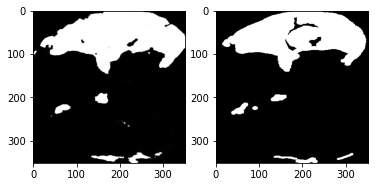


Epoch 00001: val_dice_coef improved from -inf to 0.73571, saving model to weights_save/ACL.01_0.736.h5
12/12 [==============================] - 8s 642ms/step - loss: 0.0705 - accuracy: 0.9263 - dice_coef: 0.7698 - val_loss: 0.1056 - val_accuracy: 0.9299 - val_dice_coef: 0.7357
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9279 - dice_coef: 0.7727------------------------
-------------------------


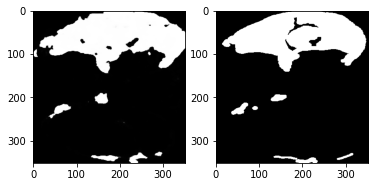


Epoch 00002: val_dice_coef did not improve from 0.73571
12/12 [==============================] - 6s 481ms/step - loss: 0.0684 - accuracy: 0.9279 - dice_coef: 0.7727 - val_loss: 0.1124 - val_accuracy: 0.9261 - val_dice_coef: 0.7270
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 0.0655 - accuracy: 0.9315 - dice_coef: 0.7673------------------------
-------------------------


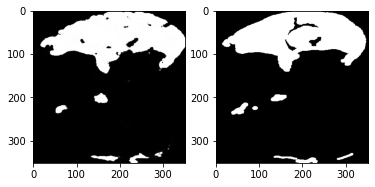


Epoch 00003: val_dice_coef did not improve from 0.73571
12/12 [==============================] - 6s 481ms/step - loss: 0.0655 - accuracy: 0.9315 - dice_coef: 0.7673 - val_loss: 0.1181 - val_accuracy: 0.9278 - val_dice_coef: 0.7113
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9241 - dice_coef: 0.7660------------------------
-------------------------


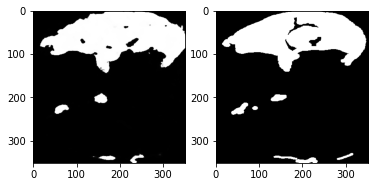


Epoch 00004: val_dice_coef did not improve from 0.73571
12/12 [==============================] - 6s 480ms/step - loss: 0.0744 - accuracy: 0.9241 - dice_coef: 0.7660 - val_loss: 0.1161 - val_accuracy: 0.9288 - val_dice_coef: 0.7251
Epoch 5/50
12/12 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.9292 - dice_coef: 0.7797------------------------
-------------------------


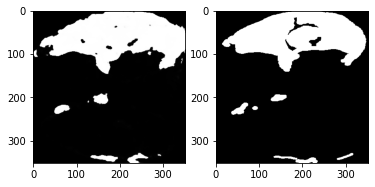


Epoch 00005: val_dice_coef did not improve from 0.73571
12/12 [==============================] - 6s 480ms/step - loss: 0.0675 - accuracy: 0.9292 - dice_coef: 0.7797 - val_loss: 0.1085 - val_accuracy: 0.9259 - val_dice_coef: 0.7329
Epoch 6/50
12/12 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9258 - dice_coef: 0.7711------------------------
-------------------------


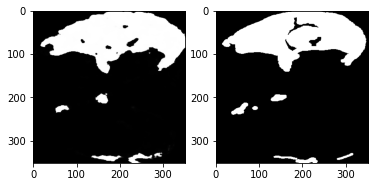


Epoch 00006: val_dice_coef did not improve from 0.73571
12/12 [==============================] - 6s 483ms/step - loss: 0.0714 - accuracy: 0.9258 - dice_coef: 0.7711 - val_loss: 0.1097 - val_accuracy: 0.9246 - val_dice_coef: 0.7102
Epoch 7/50
12/12 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9247 - dice_coef: 0.7708------------------------
-------------------------


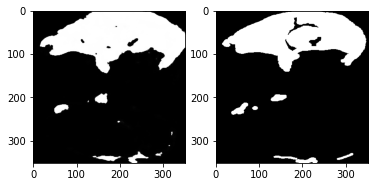


Epoch 00007: val_dice_coef did not improve from 0.73571
12/12 [==============================] - 6s 480ms/step - loss: 0.0733 - accuracy: 0.9247 - dice_coef: 0.7708 - val_loss: 0.1052 - val_accuracy: 0.9255 - val_dice_coef: 0.7325
Epoch 8/50
12/12 [==============================] - ETA: 0s - loss: 0.0657 - accuracy: 0.9308 - dice_coef: 0.7765------------------------
-------------------------


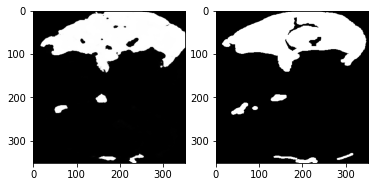


Epoch 00008: val_dice_coef did not improve from 0.73571
12/12 [==============================] - 6s 481ms/step - loss: 0.0657 - accuracy: 0.9308 - dice_coef: 0.7765 - val_loss: 0.1076 - val_accuracy: 0.9320 - val_dice_coef: 0.7312
Epoch 9/50
12/12 [==============================] - ETA: 0s - loss: 0.0669 - accuracy: 0.9302 - dice_coef: 0.7728------------------------
-------------------------


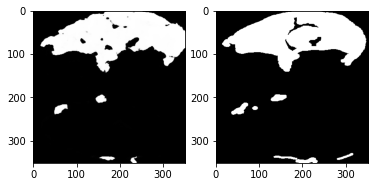


Epoch 00009: val_dice_coef did not improve from 0.73571
12/12 [==============================] - 6s 481ms/step - loss: 0.0669 - accuracy: 0.9302 - dice_coef: 0.7728 - val_loss: 0.1118 - val_accuracy: 0.9298 - val_dice_coef: 0.7191
Epoch 10/50
12/12 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9258 - dice_coef: 0.7743------------------------
-------------------------


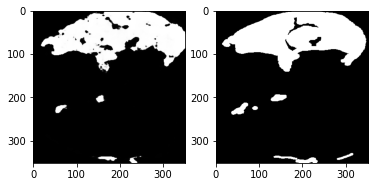


Epoch 00010: val_dice_coef did not improve from 0.73571
12/12 [==============================] - 6s 496ms/step - loss: 0.0689 - accuracy: 0.9258 - dice_coef: 0.7743 - val_loss: 0.1203 - val_accuracy: 0.9239 - val_dice_coef: 0.7214
Epoch 11/50
12/12 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.9300 - dice_coef: 0.7648------------------------
-------------------------


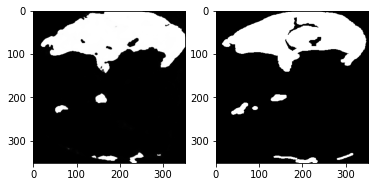


Epoch 00011: val_dice_coef improved from 0.73571 to 0.73572, saving model to weights_save/ACL.11_0.736.h5
12/12 [==============================] - 6s 516ms/step - loss: 0.0675 - accuracy: 0.9300 - dice_coef: 0.7648 - val_loss: 0.1062 - val_accuracy: 0.9306 - val_dice_coef: 0.7357
Epoch 12/50
12/12 [==============================] - ETA: 0s - loss: 0.0652 - accuracy: 0.9324 - dice_coef: 0.7738------------------------
-------------------------


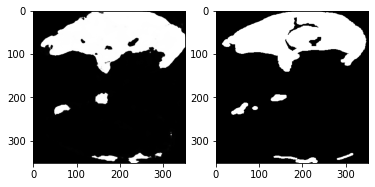


Epoch 00012: val_dice_coef did not improve from 0.73572
12/12 [==============================] - 6s 480ms/step - loss: 0.0652 - accuracy: 0.9324 - dice_coef: 0.7738 - val_loss: 0.1072 - val_accuracy: 0.9247 - val_dice_coef: 0.7331
Epoch 13/50
12/12 [==============================] - ETA: 0s - loss: 0.0652 - accuracy: 0.9314 - dice_coef: 0.7630------------------------
-------------------------


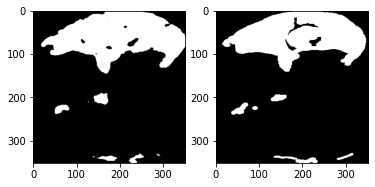


Epoch 00013: val_dice_coef improved from 0.73572 to 0.73946, saving model to weights_save/ACL.13_0.739.h5
12/12 [==============================] - 6s 506ms/step - loss: 0.0652 - accuracy: 0.9314 - dice_coef: 0.7630 - val_loss: 0.1038 - val_accuracy: 0.9312 - val_dice_coef: 0.7395
Epoch 14/50
12/12 [==============================] - ETA: 0s - loss: 0.0692 - accuracy: 0.9270 - dice_coef: 0.7694------------------------
-------------------------


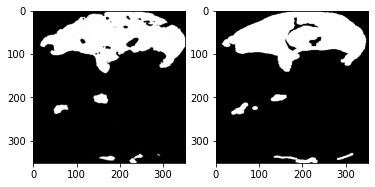


Epoch 00014: val_dice_coef did not improve from 0.73946
12/12 [==============================] - 6s 482ms/step - loss: 0.0692 - accuracy: 0.9270 - dice_coef: 0.7694 - val_loss: 0.1130 - val_accuracy: 0.9294 - val_dice_coef: 0.7249
Epoch 15/50
12/12 [==============================] - ETA: 0s - loss: 0.0657 - accuracy: 0.9302 - dice_coef: 0.7825------------------------
-------------------------


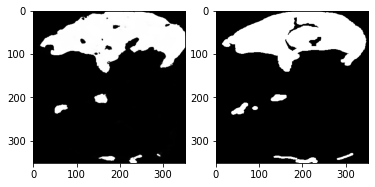


Epoch 00015: val_dice_coef did not improve from 0.73946
12/12 [==============================] - 6s 480ms/step - loss: 0.0657 - accuracy: 0.9302 - dice_coef: 0.7825 - val_loss: 0.1133 - val_accuracy: 0.9273 - val_dice_coef: 0.7201
Epoch 16/50
12/12 [==============================] - ETA: 0s - loss: 0.0605 - accuracy: 0.9350 - dice_coef: 0.7846------------------------
-------------------------


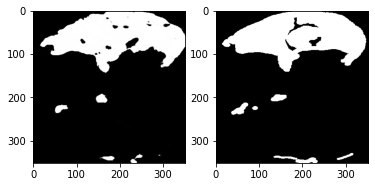


Epoch 00016: val_dice_coef did not improve from 0.73946
12/12 [==============================] - 6s 480ms/step - loss: 0.0605 - accuracy: 0.9350 - dice_coef: 0.7846 - val_loss: 0.1058 - val_accuracy: 0.9310 - val_dice_coef: 0.7312
Epoch 17/50
12/12 [==============================] - ETA: 0s - loss: 0.0650 - accuracy: 0.9306 - dice_coef: 0.7839------------------------
-------------------------


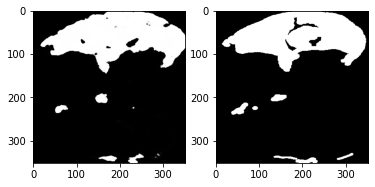


Epoch 00017: val_dice_coef improved from 0.73946 to 0.73974, saving model to weights_save/ACL.17_0.740.h5
12/12 [==============================] - 6s 503ms/step - loss: 0.0650 - accuracy: 0.9306 - dice_coef: 0.7839 - val_loss: 0.1041 - val_accuracy: 0.9307 - val_dice_coef: 0.7397
Epoch 18/50
12/12 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9327 - dice_coef: 0.7907------------------------
-------------------------


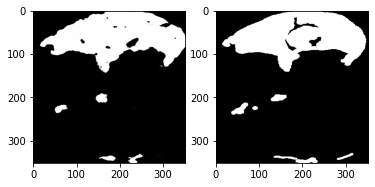


Epoch 00018: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 479ms/step - loss: 0.0623 - accuracy: 0.9327 - dice_coef: 0.7907 - val_loss: 0.1086 - val_accuracy: 0.9299 - val_dice_coef: 0.7312
Epoch 19/50
12/12 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.9309 - dice_coef: 0.7907------------------------
-------------------------


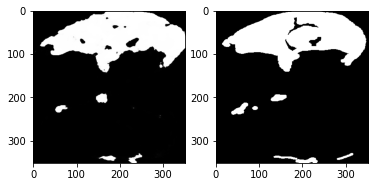


Epoch 00019: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 481ms/step - loss: 0.0636 - accuracy: 0.9309 - dice_coef: 0.7907 - val_loss: 0.1088 - val_accuracy: 0.9303 - val_dice_coef: 0.7322
Epoch 20/50
12/12 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9264 - dice_coef: 0.7759------------------------
-------------------------


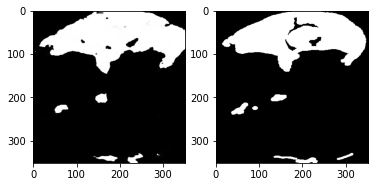


Epoch 00020: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 480ms/step - loss: 0.0689 - accuracy: 0.9264 - dice_coef: 0.7759 - val_loss: 0.1161 - val_accuracy: 0.9254 - val_dice_coef: 0.7236
Epoch 21/50
12/12 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9317 - dice_coef: 0.7755------------------------
-------------------------


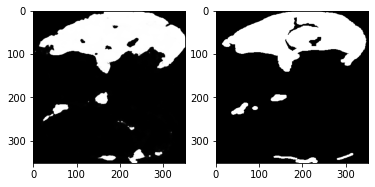


Epoch 00021: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 481ms/step - loss: 0.0643 - accuracy: 0.9317 - dice_coef: 0.7755 - val_loss: 0.1080 - val_accuracy: 0.9263 - val_dice_coef: 0.7214
Epoch 22/50
12/12 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9342 - dice_coef: 0.7846------------------------
-------------------------


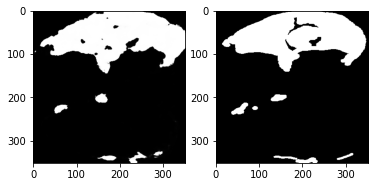


Epoch 00022: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 482ms/step - loss: 0.0626 - accuracy: 0.9342 - dice_coef: 0.7846 - val_loss: 0.1098 - val_accuracy: 0.9268 - val_dice_coef: 0.7315
Epoch 23/50
12/12 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9325 - dice_coef: 0.7886------------------------
-------------------------


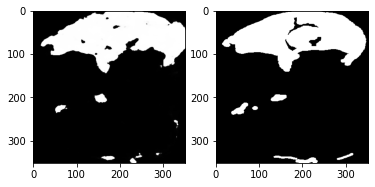


Epoch 00023: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 496ms/step - loss: 0.0626 - accuracy: 0.9325 - dice_coef: 0.7886 - val_loss: 0.1055 - val_accuracy: 0.9306 - val_dice_coef: 0.7323
Epoch 24/50
12/12 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9327 - dice_coef: 0.7804------------------------
-------------------------


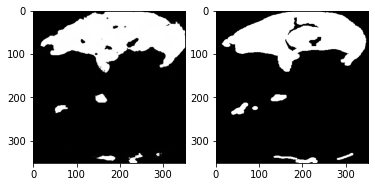


Epoch 00024: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 496ms/step - loss: 0.0623 - accuracy: 0.9327 - dice_coef: 0.7804 - val_loss: 0.1080 - val_accuracy: 0.9313 - val_dice_coef: 0.7310
Epoch 25/50
12/12 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9336 - dice_coef: 0.7923------------------------
-------------------------


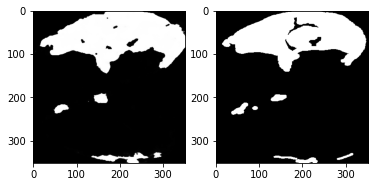


Epoch 00025: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 482ms/step - loss: 0.0616 - accuracy: 0.9336 - dice_coef: 0.7923 - val_loss: 0.1077 - val_accuracy: 0.9280 - val_dice_coef: 0.7339
Epoch 26/50
12/12 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9363 - dice_coef: 0.7914------------------------
-------------------------


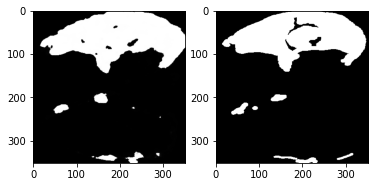


Epoch 00026: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 480ms/step - loss: 0.0575 - accuracy: 0.9363 - dice_coef: 0.7914 - val_loss: 0.1070 - val_accuracy: 0.9277 - val_dice_coef: 0.7311
Epoch 27/50
12/12 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.9328 - dice_coef: 0.7977------------------------
-------------------------


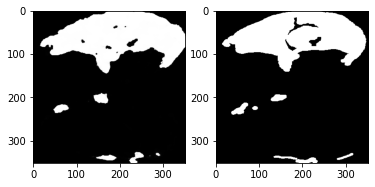


Epoch 00027: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 481ms/step - loss: 0.0618 - accuracy: 0.9328 - dice_coef: 0.7977 - val_loss: 0.1042 - val_accuracy: 0.9320 - val_dice_coef: 0.7368
Epoch 28/50
12/12 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9345 - dice_coef: 0.7956------------------------
-------------------------


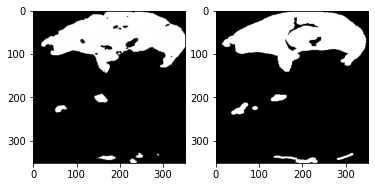


Epoch 00028: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 480ms/step - loss: 0.0580 - accuracy: 0.9345 - dice_coef: 0.7956 - val_loss: 0.1118 - val_accuracy: 0.9319 - val_dice_coef: 0.7308
Epoch 29/50
12/12 [==============================] - ETA: 0s - loss: 0.0586 - accuracy: 0.9356 - dice_coef: 0.7857------------------------
-------------------------


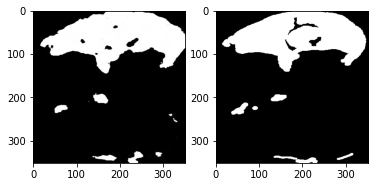


Epoch 00029: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 480ms/step - loss: 0.0586 - accuracy: 0.9356 - dice_coef: 0.7857 - val_loss: 0.1064 - val_accuracy: 0.9309 - val_dice_coef: 0.7348
Epoch 30/50
12/12 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.9342 - dice_coef: 0.8040------------------------
-------------------------


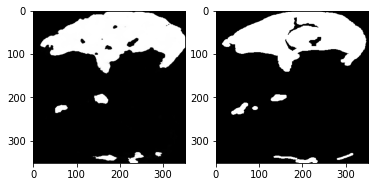


Epoch 00030: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 480ms/step - loss: 0.0592 - accuracy: 0.9342 - dice_coef: 0.8040 - val_loss: 0.1055 - val_accuracy: 0.9306 - val_dice_coef: 0.7337
Epoch 31/50
12/12 [==============================] - ETA: 0s - loss: 0.0606 - accuracy: 0.9336 - dice_coef: 0.7952------------------------
-------------------------


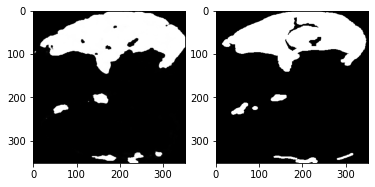


Epoch 00031: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 482ms/step - loss: 0.0606 - accuracy: 0.9336 - dice_coef: 0.7952 - val_loss: 0.1039 - val_accuracy: 0.9307 - val_dice_coef: 0.7371
Epoch 32/50
12/12 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.9349 - dice_coef: 0.8001------------------------
-------------------------


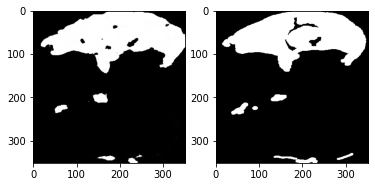


Epoch 00032: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 481ms/step - loss: 0.0592 - accuracy: 0.9349 - dice_coef: 0.8001 - val_loss: 0.1044 - val_accuracy: 0.9316 - val_dice_coef: 0.7341
Epoch 33/50
12/12 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9294 - dice_coef: 0.7975------------------------
-------------------------


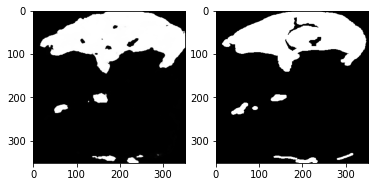


Epoch 00033: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 505ms/step - loss: 0.0638 - accuracy: 0.9294 - dice_coef: 0.7975 - val_loss: 0.1112 - val_accuracy: 0.9284 - val_dice_coef: 0.7309
Epoch 34/50
12/12 [==============================] - ETA: 0s - loss: 0.0566 - accuracy: 0.9366 - dice_coef: 0.7964------------------------
-------------------------


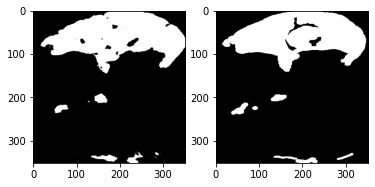


Epoch 00034: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 480ms/step - loss: 0.0566 - accuracy: 0.9366 - dice_coef: 0.7964 - val_loss: 0.1054 - val_accuracy: 0.9330 - val_dice_coef: 0.7355
Epoch 35/50
12/12 [==============================] - ETA: 0s - loss: 0.0605 - accuracy: 0.9352 - dice_coef: 0.7841------------------------
-------------------------


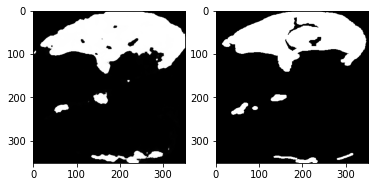


Epoch 00035: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 480ms/step - loss: 0.0605 - accuracy: 0.9352 - dice_coef: 0.7841 - val_loss: 0.1030 - val_accuracy: 0.9275 - val_dice_coef: 0.7345
Epoch 36/50
12/12 [==============================] - ETA: 0s - loss: 0.0609 - accuracy: 0.9337 - dice_coef: 0.7876------------------------
-------------------------


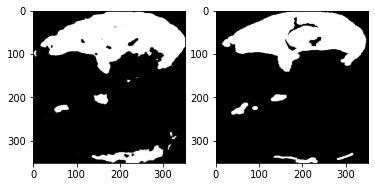


Epoch 00036: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 495ms/step - loss: 0.0609 - accuracy: 0.9337 - dice_coef: 0.7876 - val_loss: 0.1088 - val_accuracy: 0.9224 - val_dice_coef: 0.7083
Epoch 37/50
12/12 [==============================] - ETA: 0s - loss: 0.0634 - accuracy: 0.9328 - dice_coef: 0.7712------------------------
-------------------------


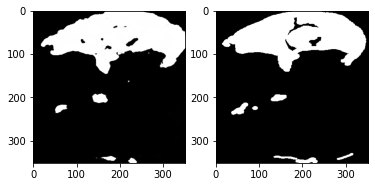


Epoch 00037: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 495ms/step - loss: 0.0634 - accuracy: 0.9328 - dice_coef: 0.7712 - val_loss: 0.1052 - val_accuracy: 0.9280 - val_dice_coef: 0.7358
Epoch 38/50
12/12 [==============================] - ETA: 0s - loss: 0.0630 - accuracy: 0.9315 - dice_coef: 0.7691------------------------
-------------------------


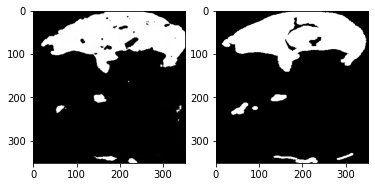


Epoch 00038: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 482ms/step - loss: 0.0630 - accuracy: 0.9315 - dice_coef: 0.7691 - val_loss: 0.1143 - val_accuracy: 0.9277 - val_dice_coef: 0.7182
Epoch 39/50
12/12 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.9313 - dice_coef: 0.7829------------------------
-------------------------


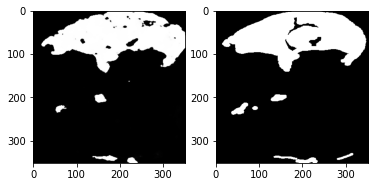


Epoch 00039: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 479ms/step - loss: 0.0620 - accuracy: 0.9313 - dice_coef: 0.7829 - val_loss: 0.1045 - val_accuracy: 0.9333 - val_dice_coef: 0.7332
Epoch 40/50
12/12 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9305 - dice_coef: 0.7863------------------------
-------------------------


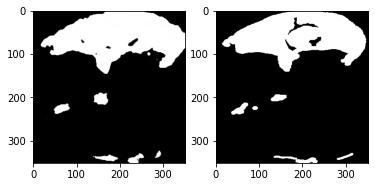


Epoch 00040: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 481ms/step - loss: 0.0637 - accuracy: 0.9305 - dice_coef: 0.7863 - val_loss: 0.1046 - val_accuracy: 0.9247 - val_dice_coef: 0.7355
Epoch 41/50
12/12 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.9327 - dice_coef: 0.7864------------------------
-------------------------


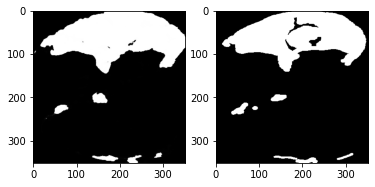


Epoch 00041: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 480ms/step - loss: 0.0615 - accuracy: 0.9327 - dice_coef: 0.7864 - val_loss: 0.1084 - val_accuracy: 0.9275 - val_dice_coef: 0.7317
Epoch 42/50
12/12 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.9366 - dice_coef: 0.7996------------------------
-------------------------


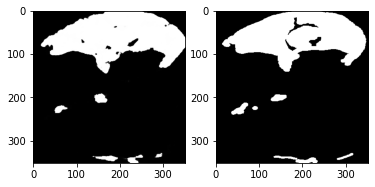


Epoch 00042: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 480ms/step - loss: 0.0564 - accuracy: 0.9366 - dice_coef: 0.7996 - val_loss: 0.1159 - val_accuracy: 0.9280 - val_dice_coef: 0.7277
Epoch 43/50
12/12 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 0.9332 - dice_coef: 0.8050------------------------
-------------------------


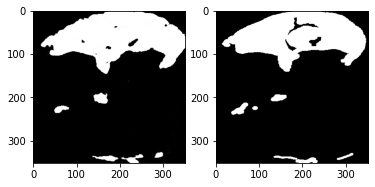


Epoch 00043: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 480ms/step - loss: 0.0595 - accuracy: 0.9332 - dice_coef: 0.8050 - val_loss: 0.1085 - val_accuracy: 0.9291 - val_dice_coef: 0.7339
Epoch 44/50
12/12 [==============================] - ETA: 0s - loss: 0.0566 - accuracy: 0.9361 - dice_coef: 0.8055------------------------
-------------------------


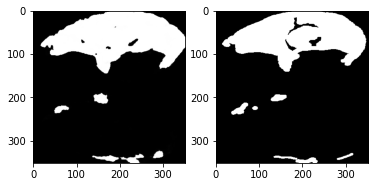


Epoch 00044: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 479ms/step - loss: 0.0566 - accuracy: 0.9361 - dice_coef: 0.8055 - val_loss: 0.1035 - val_accuracy: 0.9308 - val_dice_coef: 0.7368
Epoch 45/50
12/12 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.9347 - dice_coef: 0.8073------------------------
-------------------------


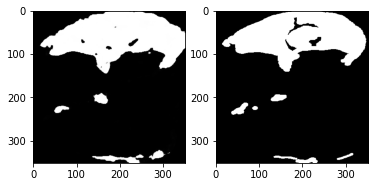


Epoch 00045: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 480ms/step - loss: 0.0578 - accuracy: 0.9347 - dice_coef: 0.8073 - val_loss: 0.1044 - val_accuracy: 0.9296 - val_dice_coef: 0.7362
Epoch 46/50
12/12 [==============================] - ETA: 0s - loss: 0.0577 - accuracy: 0.9330 - dice_coef: 0.8141------------------------
-------------------------


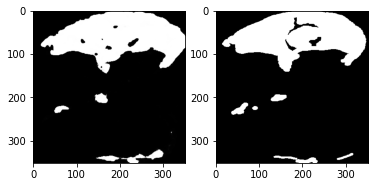


Epoch 00046: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 480ms/step - loss: 0.0577 - accuracy: 0.9330 - dice_coef: 0.8141 - val_loss: 0.1101 - val_accuracy: 0.9305 - val_dice_coef: 0.7358
Epoch 47/50
12/12 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9380 - dice_coef: 0.8065------------------------
-------------------------


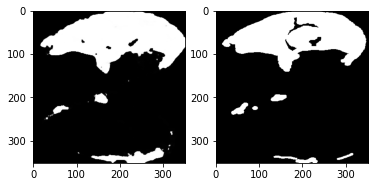


Epoch 00047: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 481ms/step - loss: 0.0538 - accuracy: 0.9380 - dice_coef: 0.8065 - val_loss: 0.1073 - val_accuracy: 0.9263 - val_dice_coef: 0.7292
Epoch 48/50
12/12 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9381 - dice_coef: 0.8043------------------------
-------------------------


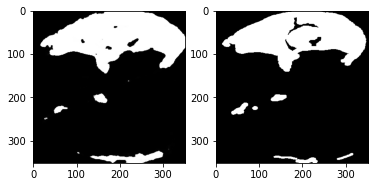


Epoch 00048: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 482ms/step - loss: 0.0544 - accuracy: 0.9381 - dice_coef: 0.8043 - val_loss: 0.1128 - val_accuracy: 0.9256 - val_dice_coef: 0.7290
Epoch 49/50
12/12 [==============================] - ETA: 0s - loss: 0.0602 - accuracy: 0.9338 - dice_coef: 0.7952------------------------
-------------------------


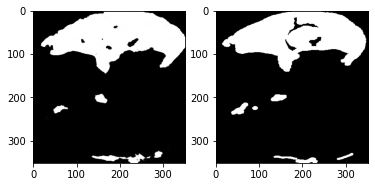


Epoch 00049: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 495ms/step - loss: 0.0602 - accuracy: 0.9338 - dice_coef: 0.7952 - val_loss: 0.1070 - val_accuracy: 0.9301 - val_dice_coef: 0.7267
Epoch 50/50
12/12 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.9363 - dice_coef: 0.7927------------------------
-------------------------


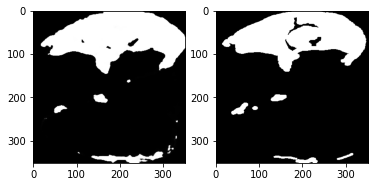


Epoch 00050: val_dice_coef did not improve from 0.73974
12/12 [==============================] - 6s 498ms/step - loss: 0.0569 - accuracy: 0.9363 - dice_coef: 0.7927 - val_loss: 0.1039 - val_accuracy: 0.9285 - val_dice_coef: 0.7365


In [ ]:
input_shape = (h, w, 3)
img = imgs[:1]
mask = masks[:1]
#plt.imshow(imgs[0,:,:,:].astype("uint8"),cmap='gray')
#plt.show()
model = unet(input_shape,2,"/content/weights_save/ACL.02_0.729.h5")
model.compile(optimizer = SGD(lr = 0.01, momentum = 0.9), loss = {"main_output":Active_Contour_Loss}, 
              metrics = {"main_output":['accuracy',dice_coef]})


checkpoint = ModelCheckpoint('weights_save/ACL.{epoch:02d}_{val_dice_coef:.3f}.h5', 
                             monitor='val_dice_coef',save_best_only=True, verbose=1, save_weights_only=True, mode='max')
#lr_decay = lr_scheduler()
callback_list = [visualize(img,mask),checkpoint]
history = model.fit(train_generator, steps_per_epoch = imgs.shape[0]//4, epochs = 50, 
                    validation_data = (img_dev, mask_dev),callbacks = callback_list,verbose = 1)

Ket qua
Dung ham heviside active contour loss tỉ lệ 1 -2 

Fine tune từ tập pseudo

loss: 0.0579 - accuracy: 0.9366 - dice_coef: 0.8038 - val_loss: 0.0918 - val_accuracy: 0.9235 - val_dice_coef: 0.7649



chạy từ đầu ảnh doctor 80 epoch step  = 100/epoch

loss: 0.0482 - accuracy: 0.9437 - dice_coef: 0.8340 - val_loss: 0.1061 - val_accuracy: 0.9329 - val_dice_coef: 0.7451


chạy từ đầu ảnh pseudo 400step/epoch


loss: 0.0359 - accuracy: 0.9481 - dice_coef: 0.8590 - val_loss: 0.1045 - val_accuracy: 0.9298 - val_dice_coef: 0.7416

#visualize 

In [ ]:
def dice_coef2(y_true, y_pred, smooth=1.0):
    '''Average dice coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes) #AhopM
    summation = K.sum(y_true + y_pred, axis=axes)
    
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)

def dice_coef_loss2(y_true, y_pred):
    return 1-dice_coef2(y_true, y_pred)

tf.Tensor(0.7638004292231648, shape=(), dtype=float64)


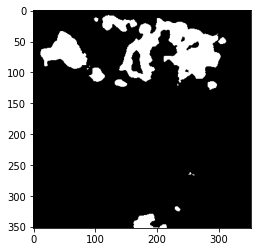

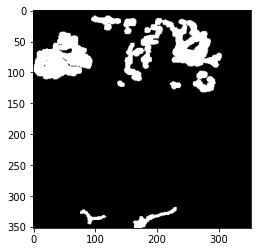

In [ ]:
model.load_weights("/content/weights_save/unet.49_0.76.h5")
mask_pred = model.predict(img_dev)
#mask_pred = heviside(mask_pred,epsilon=0.01)
mask_pred[mask_pred<0] = 0
mask_pred[mask_pred>0] = 1
print(dice_coef2(mask_dev,mask_pred))
plt.imshow(mask_pred[1,:,:,0],cmap= 'gray')
plt.show()    
plt.imshow(mask_dev[1,:,:,0],cmap= 'gray')
plt.show()

In [ ]:
for count,layer in enumerate(model.layers):
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	print(count, layer.name)
	filters, biases = layer.get_weights()


In [ ]:
ixs = [2, 5, 9, 91, 94,97]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
pyplot.imshow(imgs[0,:,:,:].astype("uint8"),cmap='gray')
pyplot.show()
feature_maps = model.predict(imgs[:1,:,:,:])
# plot the output from each block
square = 2
for fmap in feature_maps:
    print(fmap.shape)
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            if ix > fmap.shape[-1]:
                continue
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
	# show the figure
    pyplot.show()

In [ ]:
#plt.figure(1)
#plt.subplot(121,aspect='auto')
y=history.history['val_dice_coef']
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model DCS')
plt.ylabel('DCS')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#plt.subplot(122,aspect='auto')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()
